In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import seaborn as sns
import sys

%load_ext autoreload
%autoreload 2
sys.path.append("./code")
from data_processing import WMT22

sl_tls = {
    "ende" : "English-German",
    "enru" : "English-Russian",
    "zhen" : "Chinese-English" 
}

In [2]:
for key in sl_tls.keys() :
    
    val = sl_tls[key]
    
    df = WMT22.data_gold_scores(sl_tl = key)
    
    print(val , " : " , len(df) , " observations" )
    

English-German  :  32190  observations
English-Russian  :  32348  observations
Chinese-English  :  35188  observations


## III - Data Loading

In [3]:
df = WMT22.read_data()

In [4]:
for key, val in sl_tls.items() :
    
    query = df[df.sltl == key]
    
    print(val , " : " , len(query) , " observations" )
    
    print(df.sample(3)[["ref", "hyp", "score"]])
    
    print("\n")

English-German  :  32190  observations
                                                     ref  \
31157  “Last year, people were impressed by the gemin...   
6476   Wählen Sie einfach die gewünschte Gesamtanzahl...   
16414  Продление подписки оплачивается согласно стоим...   

                                                     hyp  score  
31157  “Last year, people were deeply impressed by th...    0.0  
6476   Wählen Sie einfach die gewünschte Gesamtmenge ...    0.0  
16414  Продление подписки оплачивается по цене продле...    0.0  


English-Russian  :  32348  observations
                                                     ref  \
12096  Könnten Sie bitte die Bestellnummer, den Namen...   
356    Während dieser Zeit waren wir ganz schön besch...   
13696  Проверяю информацию для Вас, это не займет мно...   

                                                     hyp  score  
12096  Können Sie die Bestellnummer, Name auf dem Kon...   -1.0  
356    Als das passierte, waren wir zieml

## IV - Vizualisations

### 1 - Usual statistics for translation pairs

In [8]:
num_segments = []
avg_score = []
num_samples = []

for key, val in sl_tls.items():
    
    query = df[df.sltl == key]
    num_samples.append(len(query))
    num_segments.append(len(query.seg_id.unique()))
    avg_score.append(round(query.score.mean(), 2))
    

In [9]:
latex = pd.DataFrame(data = {
    "sl-tl" : sl_tls.values(),
    "# samples" : num_samples,
    "# segments" : num_segments, 
    "avg score" : avg_score,
}).set_index("sl-tl")
latex.to_latex("./figures/data_description.tex", index=True, bold_rows=True, multicolumn_format='c', escape=False)

### 2 - Gold Score distribution by translation pair

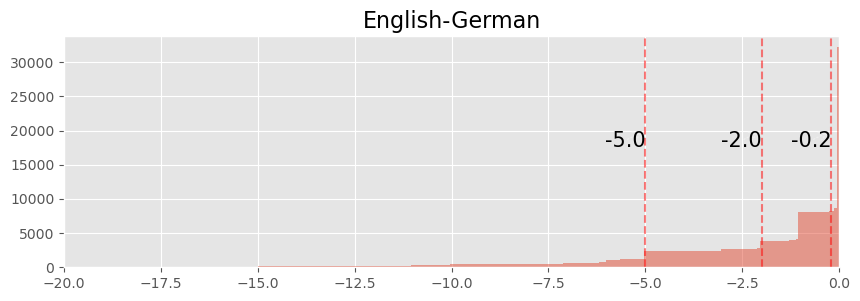

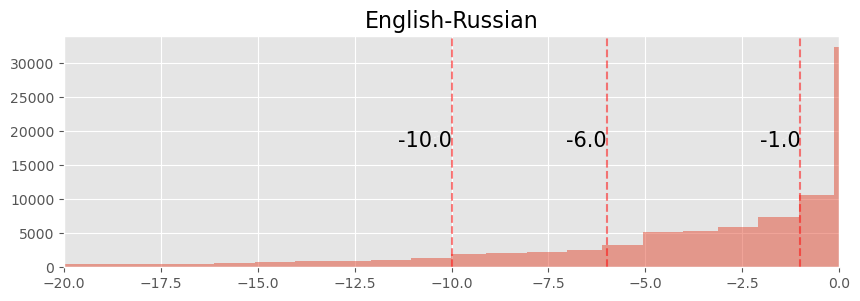

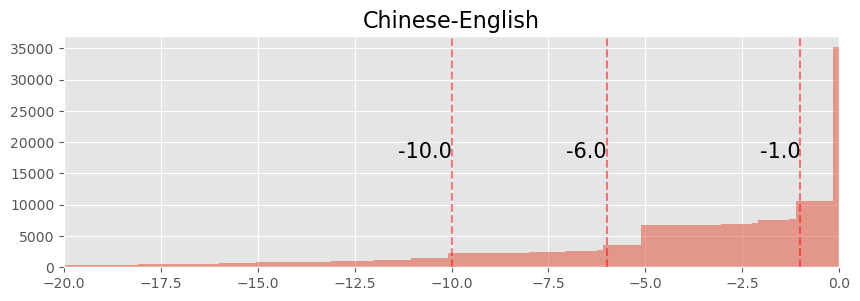

In [10]:
for sl_tl in sl_tls.keys():
    
    query = df[df.sltl == sl_tl]

    fig, ax = plt.subplots(figsize = (10,3))

    query.score.hist(
        ax=ax,
        cumulative=True,
        bins=500,
        alpha=0.5
    )
    
    quantiles = [0.05, 0.1, 0.25]

    quartiles = query.score.quantile(quantiles)

    for i, q in enumerate(quartiles.values):
        ax.axvline(q, linestyle='--', color='red', alpha=0.5)
        ax.annotate("{}".format(q), xy=(q, 20000), xytext=(q, 20000), 
                ha='right', va='top', fontsize=15, 
                arrowprops=dict(arrowstyle="->", linestyle=":", linewidth=1))

    ax.set_xlim([-20, 0])
    plt.title(sl_tls[sl_tl], size = 16)
    fig.savefig("./figures/score_quantiles_"+str(sl_tl)+'.png')

### 3 - Number of observations by domain and translation pair

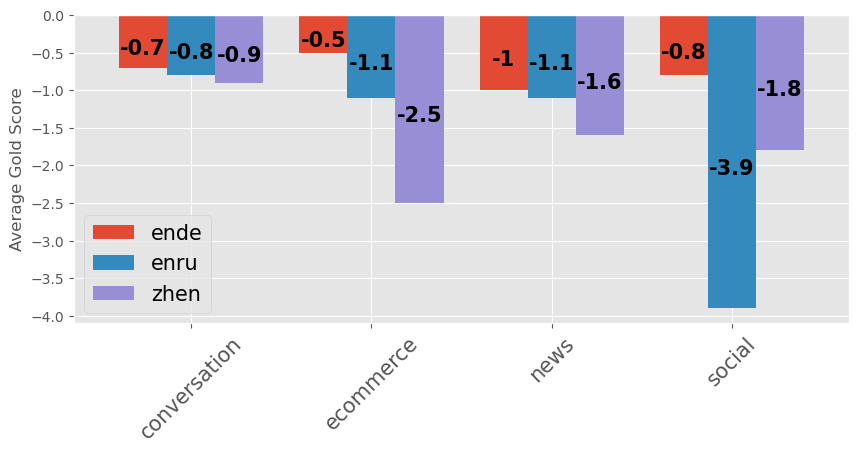

In [11]:
grouped = round(df.groupby(["domain", "sltl"]).score.mean().unstack(), 1)
mean_scores = round(df.groupby(["domain", "sltl"]).score.mean().unstack(), 1)

fig, ax = plt.subplots(figsize=(10, 4))  # Ajouter figsize pour spécifier la taille

grouped.plot(kind="bar", stacked=False, ax=ax, width=0.8)

for i, bar in enumerate(ax.containers):
    domain = mean_scores.index[i // len(mean_scores.columns)]
    score = mean_scores.iloc[i // len(mean_scores.columns), i % len(mean_scores.columns)]
    ax.bar_label(bar, label=f"{score}", fontweight='bold', fontsize=15, label_type='center', padding=5)

ax.set_ylabel("Average Gold Score")
ax.set_xlabel("")
ax.set_xticklabels(grouped.index, rotation=45, size=15)
ax.legend(fontsize=15)

plt.savefig("./figures/scores_per_domain.png", dpi=300, bbox_inches='tight')
plt.show()

### 3 - Distribution per Segment 

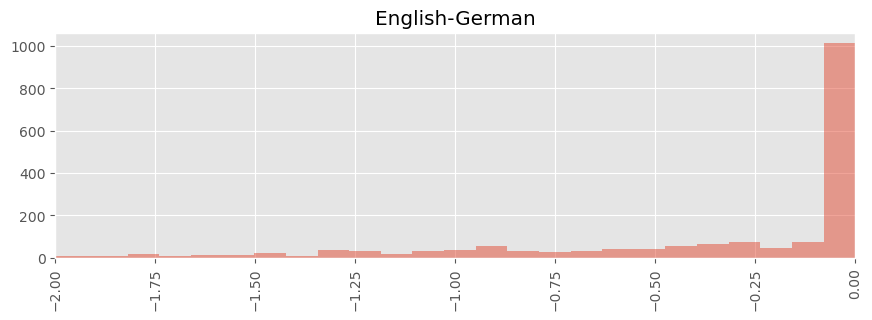

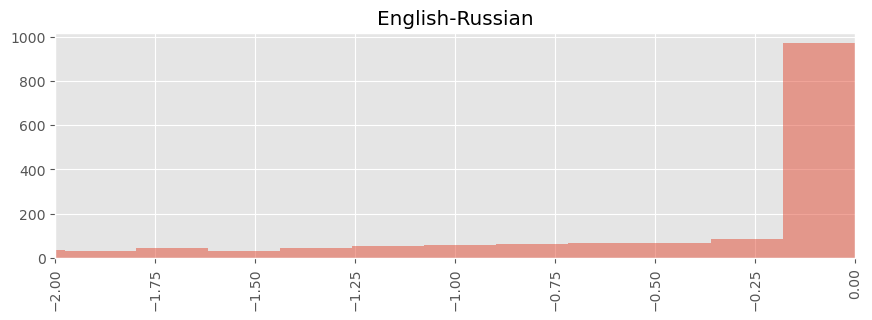

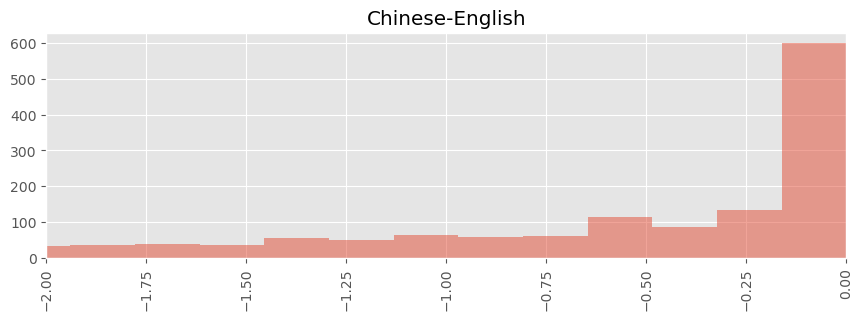

In [12]:
for sl_tl in sl_tls.keys():
    
    query = df[df.sltl == sl_tl]
    
    fig, ax = plt.subplots(figsize = (10,3))

    query.groupby("seg_id").score.mean().hist(
        by = query.sltl,
        bins = 200,
        ax = ax,
        alpha = 0.5
        )
    
    ax.set_xlim([-2, 0])
    #ax.set_xlabel("score")
    plt.title(sl_tls[sl_tl])
    fig.savefig("./figures/avg_score_segments_"+str(sl_tl)+'.png')